# Exploring `demand_gegis` outputs

### Jupyter notebook needs to be improved

The code below initialise the to be used packages. Further, `sets_path_to_root` makes sure that we set the path to your pypsa-africa folder which we need for reading files. Please, also make sure you set up the `pypsa-africa` environment which is shared as `environment.yml` in the envs folder.

In [1]:
import atlite
import cartopy.crs as ccrs
import xarray as xr
import geopandas as gpd

# import geoviews as gv
# import holoviews as hv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import pypsa
import shutil
from rasterio.plot import show
from atlite.gis import shape_availability, ExclusionContainer

# change current directory to parent folder
import os
import sys

if not os.path.isdir("pypsa-earth"):
    os.chdir("../..")
sys.path.append(os.getcwd()+"/pypsa-earth/scripts")

# plotting settings
plt.rcParams["figure.figsize"] = [7, 7]
%matplotlib inline

This is the repository path:  /home/anas/EDF/pypsa-earth-project
Had to go 2 folder(s) up.


## Let's open the demand timeseries from GEGIS
Demand timeseries are calculated in GEGIS based on paramters such as GDP, population and temperature data. Since each of this parameters can be provided in high resolution, we can derive timeseries with GEGIS for arbitrary regions for multi-years.

GEGIS is currently written in Julia. A rewrite to Python can help improving GEGIS and including other factors such as humidity, building area, building archetype information. These information will help the AI to train more accurately regional differences for demand timeseries. Alternative approaches to GEGIS such as botton-up statistical ones can also be developed in parallel.


In [3]:
demand_path = os.path.realpath("pypsa-earth") + "/data/ssp2-2.6/2030/era5_2013/Africa.nc"
demand = xr.open_dataset(demand_path)

In [4]:
demand.region_code

<xarray.DataArray 'region_code' (region_code: 57)>
array(['AO', 'BF', 'BI', 'BJ', 'BW', 'CD', 'CF', 'CG', 'CI', 'CM', 'CV', 'DJ',
       'DZ', 'EG', 'EH', 'ER', 'ET', 'GA', 'GH', 'GM', 'GN', 'GQ', 'GW', 'KE',
       'KM', 'LR', 'LS', 'LY', 'MA', 'MG', 'ML', 'MR', 'MU', 'MW', 'MZ', 'NA',
       'NE', 'NG', 'RE', 'RW', 'SC', 'SD', 'SL', 'SN', 'SO', 'SS', 'ST', 'SZ',
       'TD', 'TG', 'TN', 'TZ', 'UG', 'YT', 'ZA', 'ZM', 'ZW'], dtype=object)
Coordinates:
    region_name  (region_code) object ...
  * region_code  (region_code) object 'AO' 'BF' 'BI' 'BJ' ... 'ZA' 'ZM' 'ZW'

In [5]:
demand

<xarray.Dataset>
Dimensions:             (time: 8760, region_code: 57)
Coordinates:
  * time                (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00
    region_name         (region_code) object '' '' '' ... 'Zambia' 'Zimbabwe'
  * region_code         (region_code) object 'AO' 'BF' 'BI' ... 'ZA' 'ZM' 'ZW'
Data variables:
    Electricity demand  (region_code, time) float64 ...

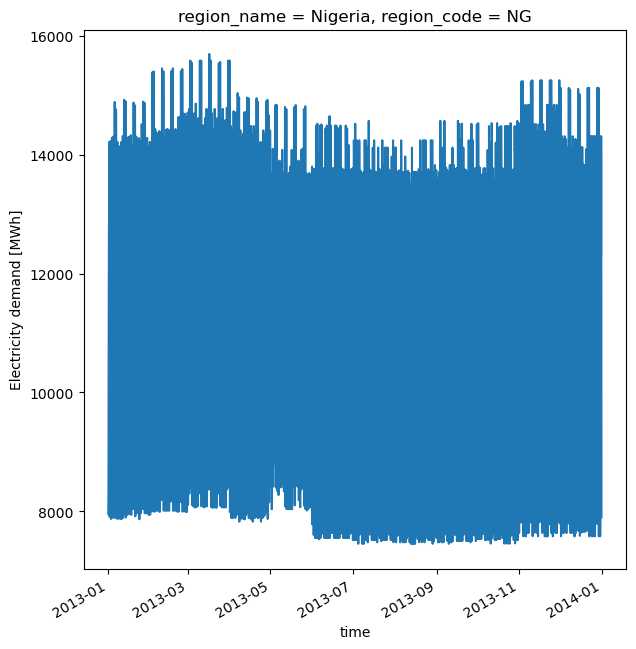

In [6]:
demand["Electricity demand"].sel(region_code="NG").plot()

# Updating demand of countries

In [7]:
countries = [
    "MW",
    "LS",
    "GN",
    "SZ",
    "GQ",
    "MG",
    "MR",
    "SL",
    "CF",
    "TD",
    "EH",
    "GM",
    "LR",
    "BF",
    "DJ",
    "RW",
    "ML",
    "SO",
    "GW",
    "BI",
]
gdp = [
    12,
    1.85,
    15.6,
    3.96,
    10,
    13.72,
    7.7,
    3.86,
    2.3,
    10,
    0.9,
    1.9,
    2.95,
    17.37,
    3.38,
    10.33,
    17.39,
    4.92,
    1.43,
    3.258,
]  # Billion USD (2020)
pop = [
    19.1,
    2.1,
    13.1,
    1.2,
    1.4,
    27.7,
    4.65,
    21.9,
    4.8,
    16.4,
    0.6,
    2.4,
    5.0,
    20.9,
    1,
    13,
    20,
    15.9,
    2,
    11.89,
]
base_country = "NG"
base_gdp = 432
base_pop = 206

In [8]:
ds = demand

In [9]:
# Updates each missing load country to Nigeria based on GDP and Nigerias timeseries
for i in range(0, len(countries), 1):
    ds.loc[dict(region_code=countries[i])] = demand.loc[dict(region_code="NG")] * (
        (gdp[i] / pop[i]) / (base_gdp / base_pop)
    )

In [10]:
# Test if Malawi has now inputs
ds.loc[dict(region_code="LR")]["Electricity demand"].sum()

<xarray.DataArray 'Electricity demand' ()>
array(27698729.90073346)
Coordinates:
    region_name  object 'Liberia'
    region_code  <U2 'LR'

## Export netcdf
uncomment the below function out to save Africa.nc (info: `.` in the path equals `os.getcwd()`)

In [11]:
# ds.to_netcdf(path="./Africa.nc")

# TEST NEW FUNCTION
Combine all weather years and predictions to one .nc file.
Unsolved challenge, how to concat the .nc files
Probably best to wait for a GEGIS Python developments

## Reading the path of all .nc files

In [12]:
ds = xr.open_dataset(
    os.path.realpath("pypsa-earth") + "/data/ssp2-2.6/2030/era5_2013/Africa.nc"
)
# Updates each missing load country to Nigeria based on GDP and Nigerias timeseries
for i in range(0, len(countries), 1):
    ds.loc[dict(region_code=countries[i])] = ds.loc[dict(region_code="NG")] * (
        (gdp[i] / pop[i]) / (base_gdp / base_pop)
    )

In [13]:
path = os.path.realpath("pypsa-earth/data/ssp2-2.6")

# we shall store all the file names in this list
filelist = []

for root, dirs, files in os.walk(path):
    for file in files:
        filename = os.path.join(root, file)

        # append the file name to the list
        filelist.append(filename)

        if filename.endswith("Africa.nc"):
            ds_new = xr.open_dataset(filename)
            root_path, rel_dir = filename.split(
                "data/"
            )  # get the relative path with respect to a specific folder
            path_modified = (
                root_path + "data_mod/" + rel_dir
            )  # relative directory where to store the modified files

            # Updates each missing load country to Nigeria based on GDP and Nigerias timeseries
            for i in range(0, len(countries), 1):
                ds_new.loc[dict(region_code=countries[i])] = ds_new.loc[
                    dict(region_code="NG")
                ] * ((gdp[i] / pop[i]) / (base_gdp / base_pop))

            os.makedirs(os.path.dirname(path_modified), exist_ok=True)
            ds_new.to_netcdf(path=path_modified)

            print(path_modified)

# print all the file names
str_end = "Africa.nc"
filelist_filtered = [x for x in filelist if x.endswith(str_end)]
filelist_filtered

/home/anas/EDF/pypsa-earth-project/pypsa-earth/data_mod/ssp2-2.6/2030/era5_2011/Africa.nc
/home/anas/EDF/pypsa-earth-project/pypsa-earth/data_mod/ssp2-2.6/2030/era5_2013/Africa.nc
/home/anas/EDF/pypsa-earth-project/pypsa-earth/data_mod/ssp2-2.6/2030/era5_2018/Africa.nc
/home/anas/EDF/pypsa-earth-project/pypsa-earth/data_mod/ssp2-2.6/2040/era5_2011/Africa.nc
/home/anas/EDF/pypsa-earth-project/pypsa-earth/data_mod/ssp2-2.6/2040/era5_2013/Africa.nc
/home/anas/EDF/pypsa-earth-project/pypsa-earth/data_mod/ssp2-2.6/2040/era5_2018/Africa.nc
/home/anas/EDF/pypsa-earth-project/pypsa-earth/data_mod/ssp2-2.6/2050/era5_2011/Africa.nc
/home/anas/EDF/pypsa-earth-project/pypsa-earth/data_mod/ssp2-2.6/2050/era5_2013/Africa.nc
/home/anas/EDF/pypsa-earth-project/pypsa-earth/data_mod/ssp2-2.6/2050/era5_2018/Africa.nc
/home/anas/EDF/pypsa-earth-project/pypsa-earth/data_mod/ssp2-2.6/2100/era5_2011/Africa.nc
/home/anas/EDF/pypsa-earth-project/pypsa-earth/data_mod/ssp2-2.6/2100/era5_2013/Africa.nc
/home/anas

['/home/anas/EDF/pypsa-earth-project/pypsa-earth/data/ssp2-2.6/2030/era5_2011/Africa.nc',
 '/home/anas/EDF/pypsa-earth-project/pypsa-earth/data/ssp2-2.6/2030/era5_2013/Africa.nc',
 '/home/anas/EDF/pypsa-earth-project/pypsa-earth/data/ssp2-2.6/2030/era5_2018/Africa.nc',
 '/home/anas/EDF/pypsa-earth-project/pypsa-earth/data/ssp2-2.6/2040/era5_2011/Africa.nc',
 '/home/anas/EDF/pypsa-earth-project/pypsa-earth/data/ssp2-2.6/2040/era5_2013/Africa.nc',
 '/home/anas/EDF/pypsa-earth-project/pypsa-earth/data/ssp2-2.6/2040/era5_2018/Africa.nc',
 '/home/anas/EDF/pypsa-earth-project/pypsa-earth/data/ssp2-2.6/2050/era5_2011/Africa.nc',
 '/home/anas/EDF/pypsa-earth-project/pypsa-earth/data/ssp2-2.6/2050/era5_2013/Africa.nc',
 '/home/anas/EDF/pypsa-earth-project/pypsa-earth/data/ssp2-2.6/2050/era5_2018/Africa.nc',
 '/home/anas/EDF/pypsa-earth-project/pypsa-earth/data/ssp2-2.6/2100/era5_2011/Africa.nc',
 '/home/anas/EDF/pypsa-earth-project/pypsa-earth/data/ssp2-2.6/2100/era5_2013/Africa.nc',
 '/home/an

In [14]:
# How to concat these nc files to one? Does it make sense